# VQE algorithm study

## Work Flow

1. Construct Hamiltonian
   1. **Mapping**:   From physical Hamiltonian to qubit-formatted Hamiltonian
   2. **Tapering**:  Simplify the Hamiltonian
2. Design circuit
   1. Select ansatz
   2. **Grouping**:  Partition the observables to groups, which also determines the measurement circuits
   3. Transpile and optimize
3. Run simulation
4. Training (find minimum)
5. Error mitigation


In [1]:
from chemistry_problems import chemical_model
from tapering import Z2_tapering

from qiskit.providers.fake_provider import FakeMontreal
from huayi_providers import FakeHuayi35

from qiskit.circuit.library import ExcitationPreserving, NLocal, TwoLocal, PauliTwoDesign
from qiskit import transpile

# Create the qubit-Hamiltonian for ·OH molecule

qubit_ham = chemical_model()

# Tapering with Z2 symmetry

tapered_ham = Z2_tapering(qubit_ham)
print(f"{tapered_ham.num_qubits} qubits remained after Z2 tapering")


"""
TODO: Grouping Observables
References:
https://arxiv.org/pdf/1907.03358.pdf
https://oar.princeton.edu/bitstream/88435/pr1jp17/1/OptSimulMeasure.pdf
https://github.com/teaguetomesh/vqe-term-grouping/blob/master/generate_measurement_circuit.py
"""

# Choose ansatz

ansatz_sc = TwoLocal(
    num_qubits=tapered_ham.num_qubits,
    rotation_blocks=['h','rz'],
    entanglement_blocks=['cx'],
    entanglement = "linear",
    reps = 3,
    insert_barriers = True,
    initial_state = None,
    flatten = True,
)
print("=== Excitation Preserving Ansatz, linear ===")
print(ansatz_sc.draw(fold=-1))

circ_sc = transpile(
    ansatz_sc,
    backend=FakeMontreal(),
    basis_gates=FakeMontreal().configuration().basis_gates, 
    optimization_level=3
)
print("=== Circuit for superconductor ===")
print(f"depth = {circ_sc.depth()}  num_params = {circ_sc.num_parameters}")
print(circ_sc.draw(fold=-1, idle_wires=False))


12 qubits in the Hamiltonian.
8 qubits remained after Z2 tapering
=== Excitation Preserving Ansatz, linear ===
     ┌───┐┌──────────┐ ░                                     ░ ┌───┐ ┌──────────┐ ░                                     ░ ┌───┐┌───────────┐ ░                                     ░ ┌───┐┌───────────┐
q_0: ┤ H ├┤ Rz(θ[0]) ├─░───■─────────────────────────────────░─┤ H ├─┤ Rz(θ[8]) ├─░───■─────────────────────────────────░─┤ H ├┤ Rz(θ[16]) ├─░───■─────────────────────────────────░─┤ H ├┤ Rz(θ[24]) ├
     ├───┤├──────────┤ ░ ┌─┴─┐                               ░ ├───┤ ├──────────┤ ░ ┌─┴─┐                               ░ ├───┤├───────────┤ ░ ┌─┴─┐                               ░ ├───┤├───────────┤
q_1: ┤ H ├┤ Rz(θ[1]) ├─░─┤ X ├──■────────────────────────────░─┤ H ├─┤ Rz(θ[9]) ├─░─┤ X ├──■────────────────────────────░─┤ H ├┤ Rz(θ[17]) ├─░─┤ X ├──■────────────────────────────░─┤ H ├┤ Rz(θ[25]) ├
     ├───┤├──────────┤ ░ └───┘┌─┴─┐                          ░ ├───┤┌┴──────────┤ ░ └───┘

## Ideal Circuits

Simulate VQE algorithm without noise model.

#### How to use

```python
model = vqe_ideal(ansatz, init_params, observable)
model.run()
```

- `ansatz` Ansatz circuit for VQE algorithm
- `init_params` Initial parameters. If set scaler, the initial parameters will be set as `init_params*randn()`
- `observable` The observable to be measured, can be the Hamiltonian

#### Results

stored in `model.values`


In [22]:
from vqe import vqe_ideal

vqe_ideal_model = vqe_ideal(
    ansatz=ansatz_sc,
    init_params=0.5,
    observable=tapered_ham,
)

vqe_ideal_model.run()

/tmp/ipykernel_535675/2342876819.py:9: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  vqe_ideal_model.run()


iter 1  	value = -9.598564994334536
iter 2  	value = -16.791138138457043
iter 3  	value = -27.676742315708974
iter 4  	value = -29.97947932229721
iter 5  	value = -32.1055072005028
iter 6  	value = -41.46397848640453
iter 7  	value = -40.97149939028596
iter 8  	value = -43.2038199316849
iter 9  	value = -43.95071462417193
iter 10  	value = -44.14731956745456
iter 11  	value = -44.59842579067274
iter 12  	value = -44.554279015468424
iter 13  	value = -43.38818372430798
iter 14  	value = -45.01569801774195
iter 15  	value = -43.00656491074803
iter 16  	value = -44.260615700695396
iter 17  	value = -44.66546081214339
iter 18  	value = -44.34944722732484
iter 19  	value = -45.143980549406436
iter 20  	value = -45.35405395468983
iter 21  	value = -48.15111053070002
iter 22  	value = -48.20164689837468
iter 23  	value = -50.36006802643573
iter 24  	value = -51.01025014663903
iter 25  	value = -50.87445236439883
iter 26  	value = -51.1355402581769
iter 27  	value = -51.710793093035846
iter 28

## Noisy Circuits

Simulate VQE algorithm with noise model.

#### How to use

```python
observables
model = vqe_with_noise(ansatz, backend, init_params, observables, *run_options)
OptmizeResults = minimize(model.fun, model.init_params, method, callback)
```

- `observables` Grouped observables
- `ansatz` Ansatz circuit for VQE algorithm
- `backend` Device backend including the noise model
- `init_params` Initial parameters. If set scaler, the initial parameters will be set as `init_params*randn()`
- `observables` The grouped observables to be measured

`run_options` should contain `shots` for each run, `seed` for the random number generator.

#### Results

stored in `model.values`

The grouping results can be found in `model.groups`, and the corresponding measurement circuits in `model.final_circuits`

#### Problems

GPU doesn't show acceleration


In [4]:
from vqe import vqe_with_noise
from qiskit.quantum_info import SparsePauliOp
from scipy.optimize import minimize

grouped_observables = SparsePauliOp.group_commuting(tapered_ham, qubit_wise=True)

run_options = {'shots': 2000, 'seed': 114514,}

vqe_model = vqe_with_noise(
    ansatz=ansatz_sc,
    backend=FakeMontreal(),
    init_params=0.5,
    observables=grouped_observables,
    run_options=run_options,
    )

Optimum = minimize(
    fun=vqe_model.fun,
    x0=vqe_model.init_params,
    method='COBYLA',
    options={"maxiter":5000},
    callback=vqe_model.store_intermediate_result,
    )

/tmp/ipykernel_535675/3970031171.py:11: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  vqe_model = vqe_with_noise(


iter 1  	value = -42.491202446340345
iter 2  	value = -41.20197925434593
iter 3  	value = -35.89637301308881
iter 4  	value = -43.18478318421448
iter 5  	value = -43.00499718833965
iter 6  	value = -42.98618392333399
iter 7  	value = -43.91027177844253
iter 8  	value = -54.33546177182321
iter 9  	value = -53.62387672357982
iter 10  	value = -54.312323995405826
iter 11  	value = -54.126370352140356
iter 12  	value = -54.13496532656916
iter 13  	value = -54.04272734758891
iter 14  	value = -54.431196963178955
iter 15  	value = -52.41691315615128
iter 16  	value = -52.6336081358443
iter 17  	value = -54.310712386221795
iter 18  	value = -45.616851488708114
iter 19  	value = -54.302050094615545
iter 20  	value = -54.28290361311813
iter 21  	value = -53.983747993682556
iter 22  	value = -55.53171523402041
iter 23  	value = -60.24312589912551
iter 24  	value = -58.96216132188943
iter 25  	value = -60.08513226966863
iter 26  	value = -59.16389836627128
iter 27  	value = -60.12068700325439
ite

Text(0, 0.5, 'Energy')

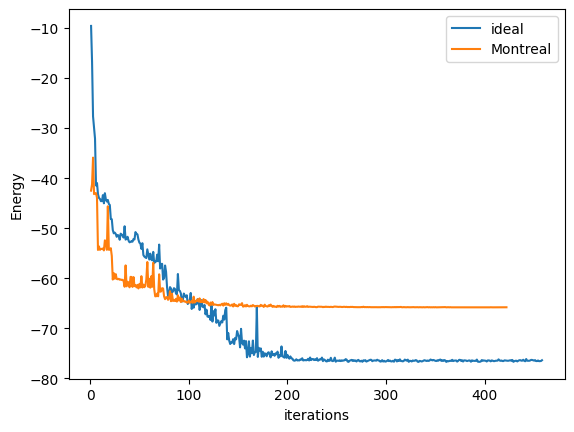

In [23]:
from matplotlib.pyplot import *

plot(vqe_ideal_model.counts, vqe_ideal_model.values, label="ideal")
plot(vqe_model.counts, vqe_model.values, label="Montreal")
legend()
xlabel("iterations")
ylabel("Energy")

In [27]:
# View the circuit including both the ansatz and measurement gates

vqe_model.final_circuits[0].assign_parameters(Optimum.x).draw(fold=-1, idle_wires=False)

global phase: π/2
           ┌─────────┐┌────┐┌─────────┐ ┌──────────────┐ ░                                     ░ ┌─────────┐┌────┐┌─────────┐┌──────────────┐ ░                                     ░ ┌─────────┐┌────┐┌─────────┐ ┌─────────────┐   ░                                     ░ ┌─────────┐┌────┐┌─────────┐┌─────────────┐  ░  ┌────────┐ ┌────┐ ┌────────┐ ░ ┌─┐                     
  q_0 -> 3 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─┤ Rz(0.093221) ├─░───■─────────────────────────────────░─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(-0.56339) ├─░───■─────────────────────────────────░─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─┤ Rz(-0.8987) ├───░───■─────────────────────────────────░─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(0.11507) ├──░──┤ Rz(-π) ├─┤ √X ├─┤ Rz(-π) ├─░─┤M├─────────────────────
           ├─────────┤├────┤├─────────┤ ├──────────────┤ ░ ┌─┴─┐                               ░ ├─────────┤├────┤├─────────┤├──────────────┤ ░ ┌─┴─┐                               ░ ├─────────┤├────┤├─────────┤ ├─────────────┴┐  ░ ┌─┴─┐                               ░ ├─────────┤├────┤├─────────┤├─────────────┤  ░ ┌┴────────┴┐├────┤┌┴────────┤ ░ └╥┘┌─┐                  
  q_1 -> 5 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─┤ Rz(-0.10729) ├─░─┤ X ├──■────────────────────────────░─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(-0.12797) ├─░─┤ X ├──■────────────────────────────░─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─┤ Rz(-0.23281) ├──░─┤ X ├──■────────────────────────────░─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(0.88488) ├──░─┤ Rz(-π/2) ├┤ √X ├┤ Rz(π/2) ├─░──╫─┤M├──────────────────
           ├─────────┤├────┤├─────────┤ └┬───────────┬─┘ ░ └───┘┌─┴─┐                          ░ ├─────────┤├────┤├─────────┤├─────────────┬┘ ░ └───┘┌─┴─┐                          ░ ├─────────┤├────┤├─────────┤┌┴──────────────┤  ░ └───┘┌─┴─┐                          ░ ├─────────┤├────┤├─────────┤├─────────────┴┐ ░ ├──────────┤├────┤├─────────┤ ░  ║ └╥┘┌─┐               
  q_2 -> 8 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├──┤ Rz(1.128) ├───░──────┤ X ├──■───────────────────────░─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(-1.1202) ├──░──────┤ X ├──■───────────────────────░─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(-0.031397) ├──░──────┤ X ├──■───────────────────────░─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(-0.76911) ├─░─┤ Rz(-π/2) ├┤ √X ├┤ Rz(π/2) ├─░──╫──╫─┤M├───────────────
           ├─────────┤├────┤├─────────┤  ├───────────┴┐  ░      └───┘  │                 ┌───┐ ░ ├─────────┤├────┤├─────────┤└┬────────────┤  ░      └───┘  │                 ┌───┐ ░ ├─────────┤├────┤├─────────┤├───────────────┴┐ ░      └───┘  │                 ┌───┐ ░ ├─────────┤├────┤├─────────┤├─────────────┬┘ ░ └┬────────┬┘├────┤└┬────────┤ ░  ║  ║ └╥┘┌─┐            
 q_7 -> 10 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├──┤ Rz(-0.344) ├──░─────────────┼─────────────────┤ X ├─░─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─┤ Rz(0.1097) ├──░─────────────┼─────────────────┤ X ├─░─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(0.00052457) ├─░─────────────┼─────────────────┤ X ├─░─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(-1.3896) ├──░──┤ Rz(-π) ├─┤ √X ├─┤ Rz(-π) ├─░──╫──╫──╫─┤M├────────────
           ├─────────┤├────┤├─────────┤  ├────────────┤  ░           ┌─┴─┐               └─┬─┘ ░ ├─────────┤├────┤├─────────┤┌┴────────────┤  ░           ┌─┴─┐               └─┬─┘ ░ ├─────────┤├────┤├─────────┤└┬──────────────┬┘ ░           ┌─┴─┐               └─┬─┘ ░ ├─────────┤├────┤├─────────┤├─────────────┴┐ ░  └────────┘ └────┘ └────────┘ ░  ║  ║  ║ └╥┘┌─┐         
 q_3 -> 11 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├──┤ Rz(-1.701) ├──░───────────┤ X ├──■──────────────┼───░─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(0.12274) ├──░───────────┤ X ├──■──────────────┼───░─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─┤ Rz(-0.42829) ├──░───────────┤ X ├──■──────────────┼───░─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(-0.33231) ├─░───────────────────────────────░──╫──╫──╫──╫─┤M├─────────
           ├─────────┤├────┤├─────────┤  ├────────────┤  ░           └───┘  │       ┌───┐  │   ░ ├─────────┤├────┤├─────────┤├─────────────┴┐ ░           └───┘  │       ┌───┐  │   ░ ├─────────┤├────┤├─────────┤ ├─────────────┬┘  ░           └───┘  │   

In [28]:
%store vqe_ideal_model
%store vqe_model

Stored 'vqe_ideal_model' (vqe_ideal)
Stored 'vqe_model' (vqe_with_noise)
